I036_I041_I052

Forest Fire Detection using Fuzzy Logic

In [1]:
!pip install ultralytics kagglehub opencv-python-headless pillow scikit-fuzzy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 66.8 MB/s eta 0:00:00


In [2]:
import kagglehub, os

# Download dataset
path = kagglehub.dataset_download("brycehopkins/flame-3-nadir-thermal-plot-subset")
print("Dataset root:", path)

# Inspect structure
for root, dirs, files in os.walk(path):
    print(root, "->", len(files), "files")
    print("   sample files:", files[:5])


100%|██████████| 32.6G/32.6G [06:54<00:00, 84.4MB/s]


Extracting files...
Dataset root: /root/.cache/kagglehub/datasets/brycehopkins/flame-3-nadir-thermal-plot-subset/versions/1
/root/.cache/kagglehub/datasets/brycehopkins/flame-3-nadir-thermal-plot-subset/versions/1 -> 0 files
   sample files: []
/root/.cache/kagglehub/datasets/brycehopkins/flame-3-nadir-thermal-plot-subset/versions/1/Hanna Hammock -> 1 files
   sample files: ['hannah_hammok_README.rtf']
/root/.cache/kagglehub/datasets/brycehopkins/flame-3-nadir-thermal-plot-subset/versions/1/Hanna Hammock/plot 3 -> 0 files
   sample files: []
/root/.cache/kagglehub/datasets/brycehopkins/flame-3-nadir-thermal-plot-subset/versions/1/Hanna Hammock/plot 3/raw_jpg_rgb -> 117 files
   sample files: ['MAX_0426.JPG', 'MAX_0519.JPG', 'MAX_0513.JPG', 'MAX_0463.JPG', 'MAX_0509.JPG']
/root/.cache/kagglehub/datasets/brycehopkins/flame-3-nadir-thermal-plot-subset/versions/1/Hanna Hammock/plot 2 -> 1 files
   sample files: ['plot2_gcp_coords.txt']
/root/.cache/kagglehub/datasets/brycehopkins/flame-3-n

Found 819 images


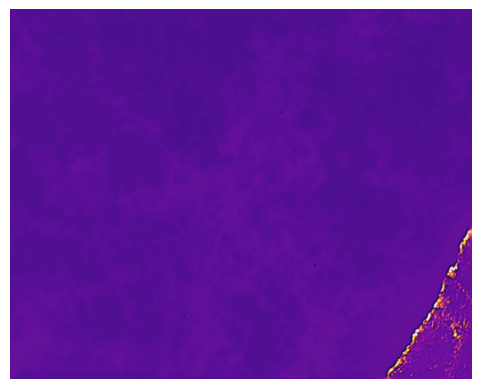

In [3]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

images = glob.glob(f"{path}/**/*.jpg", recursive=True) + glob.glob(f"{path}/**/*.png", recursive=True)
print("Found", len(images), "images")

im = Image.open(images[0])
plt.imshow(im, cmap="inferno")   # thermal colormap
plt.axis("off")
plt.show()


In [4]:
import os, glob, shutil, random
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

SRC = Path(path)  # dataset root from kagglehub
OUT = Path("/content/fire_detect_dataset")
MAX_IMAGES = 1000   # change (increase) if you want more images. Set to None to use all.
MIN_AREA = 50       # minimal connected component area in pixels (tweak)

# create dirs
for split in ["train","val"]:
    (OUT/split/"images").mkdir(parents=True, exist_ok=True)
    (OUT/split/"labels").mkdir(parents=True, exist_ok=True)

# find all image files
img_files = sorted([p for p in SRC.rglob("*.jpg")] + [p for p in SRC.rglob("*.png")])
print("Total images found:", len(img_files))
if MAX_IMAGES:
    img_files = img_files[:MAX_IMAGES]
print("Using images:", len(img_files))

def detect_hotspots_and_write(img_path, out_img_dir, out_lab_dir):
    img = cv2.imread(str(img_path))
    if img is None:
        return 0
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # threshold: use a high percentile to pick hottest pixels
    tval = int(np.percentile(blur, 97))  # tweak percentile (95-99)
    _, th = cv2.threshold(blur, tval, 255, cv2.THRESH_BINARY)
    # morphological close to join hotspots
    kernel = np.ones((5,5), np.uint8)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=1)
    # find contours
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    h_img, w_img = gray.shape
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area < MIN_AREA:
            continue
        # YOLO label normalized
        x_center = (x + w/2) / w_img
        y_center = (y + h/2) / h_img
        w_n = w / w_img
        h_n = h / h_img
        boxes.append((0, x_center, y_center, w_n, h_n))  # class 0
    # write label file (even empty file permitted)
    out_img_path = out_img_dir / img_path.name
    out_lab_path = out_lab_dir / (img_path.stem + ".txt")
    cv2.imwrite(str(out_img_path), img)
    with open(out_lab_path, "w") as f:
        for cls, xc, yc, wn, hn in boxes:
            f.write(f"{cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}\n")
    return len(boxes)

# process images and collect those with >=0 boxes
records = []
for p in img_files:
    records.append((p,))  # keep list

# split into train/val first (so both splits representative)
train_list, val_list = train_test_split([p for (p,) in records], test_size=0.15, random_state=42)

# convert and write
count_train = 0
count_val = 0
for p in train_list:
    nboxes = detect_hotspots_and_write(p, OUT/"train"/"images", OUT/"train"/"labels")
    count_train += 1
for p in val_list:
    nboxes = detect_hotspots_and_write(p, OUT/"val"/"images", OUT/"val"/"labels")
    count_val += 1

print("Wrote train images:", len(list((OUT/"train"/"images").iterdir())))
print("Wrote train labels:", len(list((OUT/"train"/"labels").iterdir())))
print("Wrote val images:", len(list((OUT/"val"/"images").iterdir())))
print("Wrote val labels:", len(list((OUT/"val"/"labels").iterdir())))


Total images found: 819
Using images: 819
Wrote train images: 696
Wrote train labels: 696
Wrote val images: 123
Wrote val labels: 123


In [5]:
DATA_YAML = "/content/fire_detect_data.yaml"
with open(DATA_YAML, "w") as f:
    f.write(f"train: {OUT}/train/images\n")
    f.write(f"val: {OUT}/val/images\n")
    f.write("\n")
    f.write("nc: 1\n")
    f.write("names: ['fire']\n")
print("Wrote", DATA_YAML)


Wrote /content/fire_detect_data.yaml


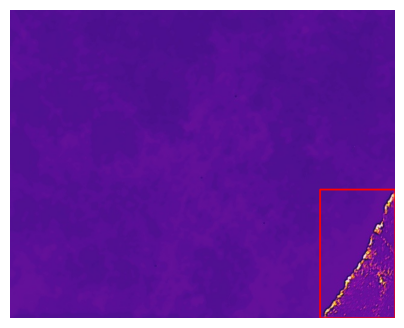

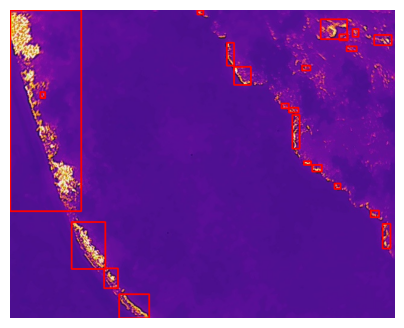

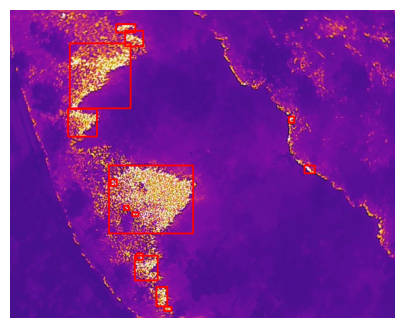

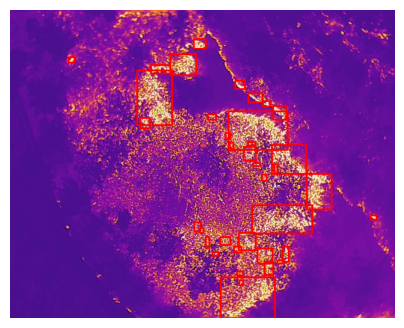

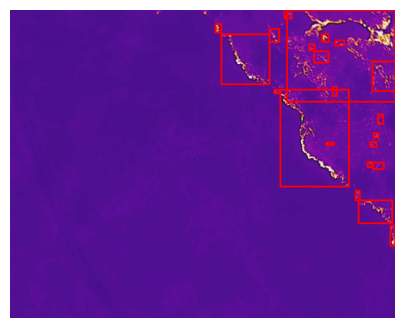

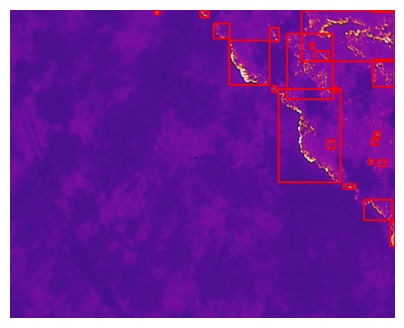

In [6]:
import random, matplotlib.pyplot as plt, cv2

sample_images = list((OUT/"val"/"images").glob("*.jpg"))[:6]
for imgp in sample_images:
    img = cv2.imread(str(imgp))
    labfile = (OUT/"val"/"labels"/(imgp.stem + ".txt"))
    if labfile.exists():
        with open(labfile) as f:
            for line in f:
                cls, xc, yc, wn, hn = line.split()
                xc, yc, wn, hn = map(float, (xc, yc, wn, hn))
                h,w = img.shape[:2]
                x1 = int((xc - wn/2) * w)
                y1 = int((yc - hn/2) * h)
                x2 = int((xc + wn/2) * w)
                y2 = int((yc + hn/2) * h)
                cv2.rectangle(img, (x1,y1), (x2,y2), (0,0,255), 2)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4)); plt.imshow(img_rgb); plt.axis("off")


In [7]:
from ultralytics import YOLO

# choose small model for Colab; if GPU enabled, training is faster
model = YOLO("yolov8n.pt")

# Train – set epochs larger for better results (I use 20 here; change if you have limited time)
model.train(data=DATA_YAML, epochs=20, imgsz=640, batch=8, name="fire_detect")
# After training, best weights are in: /content/runs/detect/fire_detect/weights/best.pt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/fire_detect_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c13d64cc8c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [8]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Inputs (unchanged)
temp_intensity = ctrl.Antecedent(np.arange(0, 256, 1), 'temp_intensity')
hotspot_size   = ctrl.Antecedent(np.arange(0, 1000000, 1), 'hotspot_size')
confidence     = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'confidence')

# Output: fire danger index class mapped to 0–100 scale
fire_danger = ctrl.Consequent(np.arange(0, 101, 1), 'fire_danger')

# --- Memberships for inputs (you can keep or adjust) ---
temp_intensity['low']    = fuzz.trimf(temp_intensity.universe, [0, 0, 100])
temp_intensity['medium'] = fuzz.trimf(temp_intensity.universe, [50, 128, 200])
temp_intensity['high']   = fuzz.trimf(temp_intensity.universe, [150, 255, 255])

hotspot_size['small']    = fuzz.trimf(hotspot_size.universe, [0, 0, 2500])
hotspot_size['medium']   = fuzz.trimf(hotspot_size.universe, [2000, 8000, 20000])
hotspot_size['large']    = fuzz.trimf(hotspot_size.universe, [15000, 100000, 100000])

confidence['low']        = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence['medium']     = fuzz.trimf(confidence.universe, [0.3, 0.6, 0.9])
confidence['high']       = fuzz.trimf(confidence.universe, [0.7, 1.0, 1.0])

#New Memberships for output: 5 danger levels
# Mapping to 0–100 range: you can interpret ranges roughly as:
# Low ~ 0–20, Moderate ~ 15–35, High ~ 30–55, Very High ~ 50–80, Extreme ~ 75–100

fire_danger['low']       = fuzz.trimf(fire_danger.universe, [0, 0, 20])
fire_danger['moderate']  = fuzz.trimf(fire_danger.universe, [10, 30, 45])
fire_danger['high']      = fuzz.trimf(fire_danger.universe, [35, 50, 65])
fire_danger['very_high'] = fuzz.trimf(fire_danger.universe, [55, 70, 85])
fire_danger['extreme']   = fuzz.trimf(fire_danger.universe, [75, 100, 100])

# Rules (example)
rules = [
    ctrl.Rule(temp_intensity['high'] & hotspot_size['large'] & confidence['high'], fire_danger['extreme']),
    ctrl.Rule(temp_intensity['high'] & hotspot_size['medium'], fire_danger['very_high']),
    ctrl.Rule(temp_intensity['medium'] & hotspot_size['medium'] & confidence['medium'], fire_danger['high']),
    ctrl.Rule(temp_intensity['low'] & confidence['low'], fire_danger['low']),
    # add more rules combining inputs to cover all cases
]

fire_ctrl = ctrl.ControlSystem(rules)
fire_sim = ctrl.ControlSystemSimulation(fire_ctrl)


In [10]:
# Assign dummy values for demonstration
intensity = 180  # Example intensity
area = 10000  # Example area
conf = 0.85 # Example confidence

fire_sim.input['temp_intensity'] = intensity
fire_sim.input['hotspot_size'] = area
fire_sim.input['confidence'] = conf
fire_sim.compute()
danger_value = fire_sim.output['fire_danger']

# Map crisp danger_value to class
if danger_value < 20:
    label = "LOW"
elif danger_value < 45:
    label = "MODERATE"
elif danger_value < 65:
    label = "HIGH"
elif danger_value < 85:
    label = "VERY HIGH"
else:
    label = "EXTREME"

print(f"Fire danger level: {label} (Value: {danger_value:.2f})")

# then draw box & label on frame

Fire danger level: HIGH (Value: 62.58)


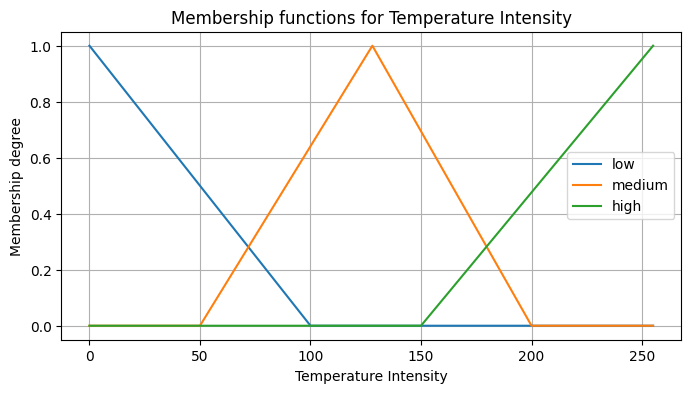

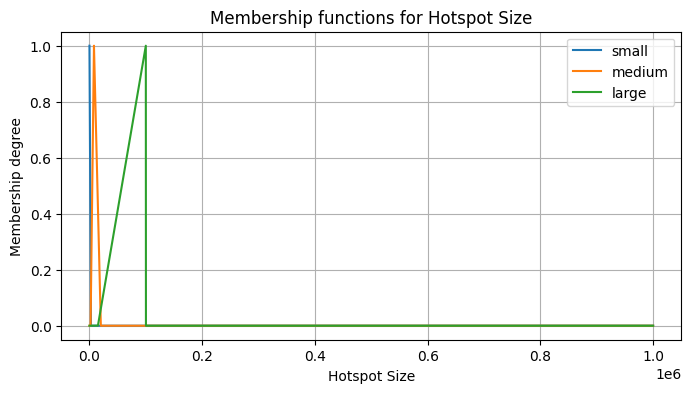

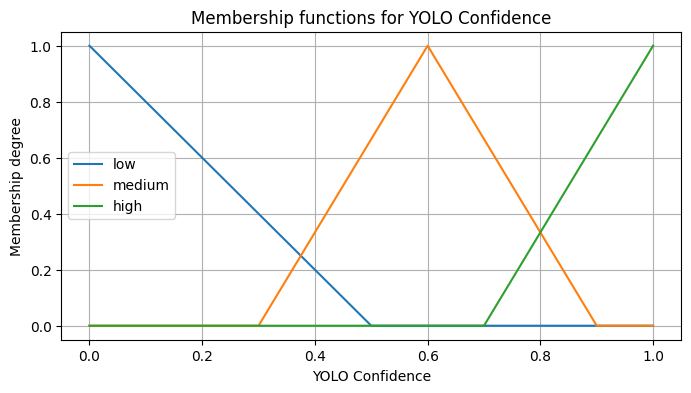

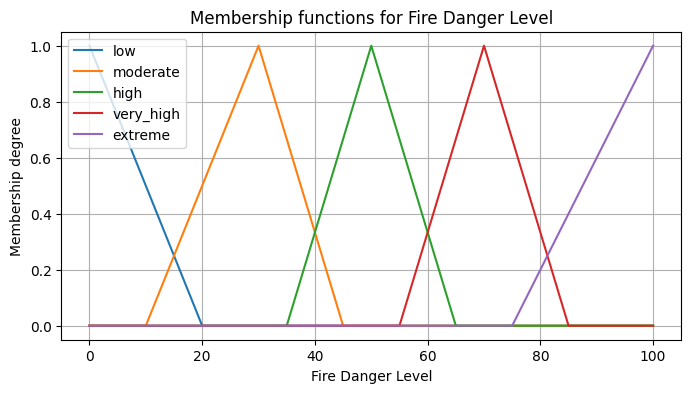

In [11]:
import matplotlib.pyplot as plt

# Function to plot membership functions
def plot_mfs(var, var_name):
    plt.figure(figsize=(8,4))
    for term in var.terms:
        mf = var[term].mf
        plt.plot(var.universe, mf, label=term)
    plt.title(f"Membership functions for {var_name}")
    plt.xlabel(var_name)
    plt.ylabel("Membership degree")
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot inputs
plot_mfs(temp_intensity, "Temperature Intensity")
plot_mfs(hotspot_size, "Hotspot Size")
plot_mfs(confidence, "YOLO Confidence")


# Plot output
plot_mfs(fire_danger, "Fire Danger Level")


In [16]:
import cv2, numpy as np, glob
from google.colab import files


# Synthetic video from validation images
img_dir = "/content/fire_detect_dataset/val/images"
images = sorted(glob.glob(img_dir + "/*.jpg"))[:50]  # up to 50 frames for demo

video_out = "/content/fire_detection_demo_FWI.mp4"
if len(images) == 0:
    raise Exception("No images found in val set!")

# Get W,H from first image (force consistent size)
sample = cv2.imread(images[0])
H, W = sample.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(video_out, fourcc, 5, (W, H))  # 5 fps demo


# Function: draw legend bar

def draw_legend(frame):
    legend = [
        ("LOW", (0,255,0)),
        ("MODERATE", (255,255,0)),
        ("HIGH", (0,165,255)),
        ("VERY HIGH", (0,140,255)),
        ("EXTREME", (0,0,255)),
    ]
    start_x, start_y = 10, 30
    box_h, box_w = 20, 80
    gap = 5

    for i,(label,color) in enumerate(legend):
        y = start_y + i*(box_h+gap)
        cv2.rectangle(frame, (start_x, y), (start_x+box_w, y+box_h), color, -1)
        cv2.putText(frame, label, (start_x+box_w+10, y+15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)


# Process frames

for frame_idx, img_path in enumerate(images):
    frame = cv2.imread(img_path)

    # Resize to (W,H) if inconsistent
    if frame.shape[:2] != (H,W):
        frame = cv2.resize(frame, (W,H))

    results = model.predict(frame, imgsz=640, conf=0.25, verbose=False)[0]

    if hasattr(results, "boxes") and len(results.boxes) > 0:
        for box in results.boxes:
            xy = box.xyxy.cpu().numpy()[0]
            x1,y1,x2,y2 = map(int, xy.tolist())
            conf = float(box.conf.cpu().numpy()[0])

            crop = frame[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            intensity = float(np.mean(gray))
            area = float((x2-x1)*(y2-y1))

            # Fuzzy inputs
            fire_sim.input['temp_intensity'] = intensity
            fire_sim.input['hotspot_size'] = area
            fire_sim.input['confidence'] = conf

            try:
                fire_sim.compute()
                danger_value = fire_sim.output['fire_danger']
            except:
                danger_value = 0.0

            # Danger class mapping
            if danger_value < 20:
                label = "LOW"; color = (0,255,0)
            elif danger_value < 45:
                label = "MODERATE"; color = (255,255,0)
            elif danger_value < 65:
                label = "HIGH"; color = (0,165,255)
            elif danger_value < 85:
                label = "VERY HIGH"; color = (0,140,255)
            else:
                label = "EXTREME"; color = (0,0,255)

            # Draw detection + fuzzy label
            cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
            cv2.putText(frame, f"{label} ({danger_value:.1f})",
                        (x1, max(20,y1-8)), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, color, 2)

    # Add legend on every frame
    draw_legend(frame)

    out.write(frame)

out.release()
print(" Video saved to:", video_out)


files.download(video_out)

 Video saved to: /content/fire_detection_demo_FWI.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>